In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import deque
from scipy import stats
import sys

In [2]:
np.random.seed(1234)

x_data = np.random.normal(170.0, np.sqrt(49), 100) # 100 人分のデータ
n = len(x_data)

B = 100
N = 100000 + B
epsilon = 0.01
L = 100
initial = np.array([168, 49]) # 平均, 分散

In [3]:
x_data

array([173.30004615, 161.66317014, 180.02894878, 167.81143673,
       164.95587887, 176.21014058, 176.0171189 , 165.54433547,
       170.1098746 , 154.30120532, 178.05025007, 176.94362216,
       176.6732689 , 155.85121626, 167.66145844, 170.01482855,
       172.83817388, 172.02364359, 179.24810734, 159.17166113,
       168.58147573, 165.40821459, 171.35394964, 173.87407238,
       179.22706088, 166.71486301, 174.7288786 , 157.28080941,
       168.71824022, 177.41278431, 167.2151184 , 172.36206358,
       177.33305001, 177.32156779, 176.04602104, 169.14535898,
       170.87299068, 167.74043636, 175.89172299, 186.73672361,
       170.53339711, 166.03487849, 170.25299356, 155.4751568 ,
       171.7345454 , 163.71990251, 169.04243617, 170.12802434,
       175.28789788, 171.50688007, 175.88706156, 159.87932946,
       160.18618703, 169.2935726 , 166.16230286, 168.98766344,
       172.47814233, 169.75140882, 173.96016814, 180.81961163,
       163.18034566, 169.50758586, 172.15578199, 168.54

In [4]:
def leapfrog(theta, p, h_prime):
    half_next_p = p - (epsilon * h_prime(theta)) / 2
    next_theta = theta + epsilon * half_next_p
    next_p = half_next_p - (epsilon * h_prime(next_theta)) / 2
    return (next_p, next_theta)

In [5]:
def hamiltonian(theta, p, h):
    return (
        h(theta)
        + (
            np.sum(p ** 2) # 各次元がもつ運動エネルギーの足し合わせ
             / 2
        )
    )

In [6]:
def r(theta1, p1, theta2, p2, h):
    return (
        np.exp(hamiltonian(theta1, p1, h) - hamiltonian(theta2, p2, h))
    )

In [7]:
def hmc(h, h_prime):
    data = np.empty((N, len(initial)))
    data[0] = initial
    accept_count = 1 # data[0] は受容とみなす
    for i in range(1, N):
        if not i % 1000: # 進捗用
            sys.stdout.write("%s / %s %s %%  \r" % (i, N, np.round(100 * (i / N), decimals=2)))
            
        start_p = p = np.random.normal(0, 1, len(initial))
        start_theta = theta = data[i - 1]

        for _ in range(L):
            p, theta = leapfrog(theta, p, h_prime)

        if np.random.rand() < r(start_theta, start_p, theta, p, h):
            data[i] = theta
            accept_count = accept_count + 1
        else:
            data[i] = start_theta
            
    print("\nacceptance ratio: %s " % str(accept_count / N))
    
    return data

In [8]:
def h(theta):
    """
    目標分布（事後確率）関数の対数関数のマイナス。必ずスカラー値を返却させる
    """
    [mu, sigma2] = theta
    return ((n * np.log(sigma2)/(-2)) - (np.sum((x_data - mu) ** 2) / (2 * sigma2))) * -1

def h_prime(theta):
    """
    目標分布関数の対数関数の微分のマイナス
    """
    [mu, sigma2] = theta
    ret = np.empty(2)
    
    # d/dμ
    ret[0] = np.sum(x_data - mu) / sigma2

    # d/dσ^2
    ret[1] = -n / (2 * sigma2) + np.sum((x_data - mu) ** 2) / (2 * sigma2 * sigma2)
    return -ret

data = hmc(
    h,
    h_prime
)

100000 / 100100 99.9 %  
acceptance ratio: 0.99998001998002 


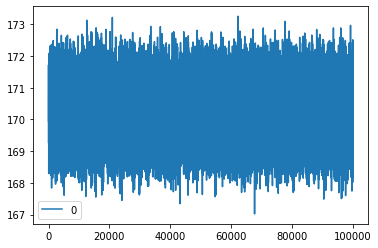

In [9]:
# 平均のトレースプロット
pd.DataFrame(data[B:,0]).plot()

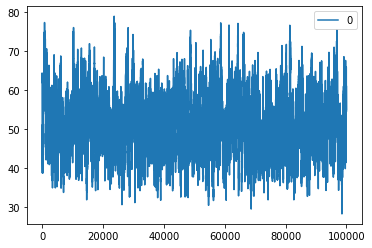

In [10]:
# 分散のトレースプロット
pd.DataFrame(data[B:,1]).plot()

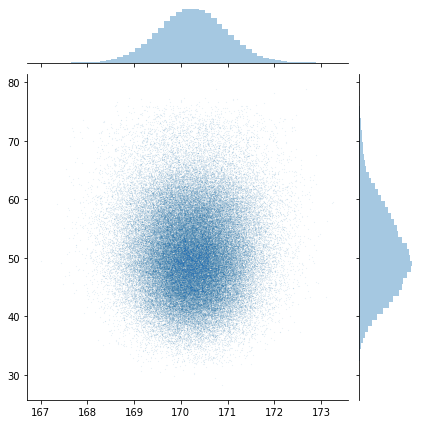

In [25]:
# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)
sns.jointplot(data[B:,0], data[B:,1], s=0.001)